In [1]:
%load_ext autoreload
%autoreload 2

## Multiple Choice Question Answer

In [386]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_auc_score
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
import pycountry
import re
import nltk
from nltk.corpus import stopwords

tqdm.pandas()

In [264]:
nltk.download('stopwords')

# Prepare country and nationality patterns
def prepare_patterns():
    countries = [country.name for country in pycountry.countries]
    country_alpha3 = [country.alpha_3 for country in pycountry.countries]  # 3-letter codes
    country_alpha2 = [country.alpha_2 for country in pycountry.countries]  # 2-letter codes
    nationalities = [getattr(country, 'demonym', None) for country in pycountry.countries if hasattr(country, 'demonym')]
    nationalities = [nat for nat in nationalities if nat]  # Filter out None values

    # Combine all patterns
    patterns = countries + country_alpha3 + country_alpha2 + nationalities
    return sorted(patterns, key=len, reverse=True)

# Compile regex for countries and nationalities
patterns = prepare_patterns()
combined_pattern = re.compile(r'\b(' + '|'.join(re.escape(item) for item in patterns) + r')\b', flags=re.IGNORECASE)

# Function to process text
def process_text(text, stop_words, pattern=combined_pattern):
    placeholder_count = 0
    placeholder_map = {}

    # Replace countries and nationalities
    def replace_match(match):
        nonlocal placeholder_count
        match_text = match.group(0).lower()
        if match_text not in placeholder_map:
            placeholder_count += 1
            placeholder_map[match_text] = f"Country {chr(64 + placeholder_count)}"
        return placeholder_map[match_text]

    text = pattern.sub(replace_match, text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Tokenize and remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return ' '.join(filtered_words)

# Main Pandas Workflow
def process_dataframe(df, text_column):
    # Load stopwords
    stop_words = set(stopwords.words('english'))

    # Apply processing to the specified text column
    df['ProcessedText'] = df[text_column].progress_apply(lambda x: process_text(x, stop_words))
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2022/pedro.silva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [265]:
mapper = defaultdict(lambda : 1)
mapper['no'] = 0

In [267]:
all_df = []
for idx in range(1,5):
    temp = pd.read_csv(f"data/real_labels_{idx}.csv", index_col=0)
    all_df.append(temp)

df = pd.concat(all_df).drop_duplicates("originalTweet")
df =process_dataframe(df, "originalTweet")

df['label'] = df['event'].map(mapper)

df.loc[(df['EventType'] == 0) & (df['label'] == 1), 'label'] = 0
# wrong_labels

100%|██████████| 37257/37257 [00:04<00:00, 8285.08it/s]


## Training model

In [269]:
df['ProcessedText'].iloc[8]

'Country Country B get fined green laser goalies face'

In [270]:
df['MatchID'].value_counts()

MatchID
4     11516
13    11186
11     9412
8      3012
7      1000
2       623
0       508
Name: count, dtype: int64

In [271]:
train_text = df.query("MatchID in [4,13,11]")
val_text = df.query("MatchID not in [4,13,11]")

In [341]:
forced_words = forced_words = [
    "goal", "penalty", "halftime", "full-time", "yellow", "red",
    "kickoff", "extra time", "stoppage time", "foul", "offside", "handball",
    "save", "tackle", "dribble", "corner", "substitution", "header",
    "free kick", "throw-in", "assist", "hat-trick", "own goal", "victory",
    "defeat", "draw", "win", "loss", "tie", "comeback", "goalkeeper",
    "striker", "midfielder", "defender", "referee", "fans", "var"
]  # Words to force into the vectorizer
custom_vocab = {word: i for i, word in enumerate(forced_words)}

vectorizer = TfidfVectorizer(max_features=30)
vectorizer.fit_transform(train_text['ProcessedText'])

original_vocab = set(vectorizer.get_feature_names_out())

# Combine original vocabulary with forced words
combined_vocab = sorted(original_vocab.union(forced_words))

# Reinitialize the vectorizer with the combined vocabulary
vectorizer = TfidfVectorizer(vocabulary=combined_vocab)

In [342]:
features_train = vectorizer.fit_transform(train_text['ProcessedText'])
target_train = train_text['label']

In [387]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=5)

In [388]:
features_val = vectorizer.transform(val_text['ProcessedText'])
target_val = val_text['label']

In [389]:
y_pred_val = clf.predict_proba(features_val)

In [390]:
precision_score(target_val, y_pred_val[:,1] > 0.5)

0.8162162162162162

In [391]:
roc_auc_score(target_val, y_pred_val[:,1])

0.6503702167989576

In [392]:
confusion_matrix(target_val, y_pred_val[:,1] > 0.5)

array([[3235,   68],
       [1538,  302]])

In [393]:
train, test = train_test_split()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


In [283]:
test.keys()

dict_keys([1, 3, 5, 10, 12, 17])

In [363]:
new_df = pd.concat([test[10]])

In [364]:
new_df = process_dataframe(new_df, "Tweet")

  0%|          | 0/280010 [00:00<?, ?it/s]

100%|██████████| 280010/280010 [00:31<00:00, 8829.94it/s] 


In [394]:
vectors_test = vectorizer.transform(new_df['ProcessedText'])

In [395]:
probas = clf.predict_proba(vectors_test)[:,1]

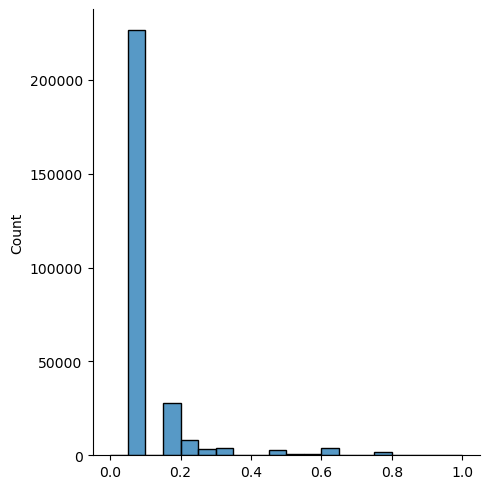

In [396]:
sns.displot(probas)

In [397]:
new_df['proba'] = probas

In [398]:
pred = new_df.groupby(["MatchID", "PeriodID"], as_index=False).agg({
    "proba": np.max,
    "EventType": np.mean
})

merged_df = pd.merge(
    new_df,
    pred[["MatchID", "PeriodID", 'proba']],
    on = ["MatchID", "PeriodID"]
)

/tmp/ipykernel_63944/3543115267.py:1: FutureWarning: The provided callable <function max at 0x7f8e91295260> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  pred = new_df.groupby(["MatchID", "PeriodID"], as_index=False).agg({
/tmp/ipykernel_63944/3543115267.py:1: FutureWarning: The provided callable <function mean at 0x7f8e91295c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pred = new_df.groupby(["MatchID", "PeriodID"], as_index=False).agg({


In [399]:
pred.head(20)

,MatchID,PeriodID,proba,EventType
0,10,0,0.583333,0.0
1,10,1,0.610101,0.0
2,10,2,0.461765,0.0
3,10,3,0.762500,0.0
4,10,4,0.610101,0.0
5,10,5,0.762500,0.0
6,10,6,0.762500,1.0
7,10,7,0.937500,1.0
8,10,8,0.610101,0.0
9,10,9,0.762500,1.0


In [400]:
accuracy_score(merged_df['EventType'],merged_df['proba_y'] > 1/2)

0.3826149066104782